In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Create directories for outputs
os.makedirs('data', exist_ok=True)
os.makedirs('exploratory_data_analysis', exist_ok=True)
os.makedirs('preprocessing', exist_ok=True)
os.makedirs('correlation_analysis', exist_ok=True)
os.makedirs('time_series_analysis', exist_ok=True)
os.makedirs('final_report/figures', exist_ok=True)
os.makedirs('modelling_analysis_results', exist_ok=True)

######################################################################
## Phase 1: Data Loading and Initial Examination
######################################################################

In [ ]:
print("Phase 1: Data Loading and Initial Examination")

In [ ]:
# Load the dataset
airquality = pd.read_excel('Dataset/AirQualityUCI.xlsx')

In [ ]:
airquality.head()

In [ ]:
print(f"Dataset shape: {airquality.shape}")

In [ ]:
print("\nColumn names:")
print(airquality.columns.tolist())

In [ ]:
airquality.info()

In [ ]:
print("\nData types:")
print(airquality.dtypes)

In [ ]:
airquality.describe()

In [ ]:
airquality.isnull().sum()

In [ ]:
# Check for missing values (represented as -200)
print("\nChecking for -200 values (missing data):")
for col in airquality.columns:
    if isinstance(airquality[col].min(), (int, float)) and airquality[col].min() == -200:
        print(f"{col} has -200 values: {(airquality[col] == -200).sum()} ({(airquality[col] == -200).sum()/len(airquality)*100:.2f}%)")

In [ ]:
# Replace -200 with NaN
airquality = airquality.copy()
for col in airquality.columns:
    if airquality[col].dtype != 'datetime64[ns]' and airquality[col].dtype != 'object':
        airquality[col] = airquality[col].replace(-200, np.nan)

In [ ]:
# Check for missing values (represented as -200)
print("\nChecking for -200 values (missing data):")
for col in airquality.columns:
    if isinstance(airquality[col].min(), (int, float)) and airquality[col].min() == -200:
        print(f"{col} has -200 values: {(airquality[col] == -200).sum()} ({(airquality[col] == -200).sum()/len(airquality)*100:.2f}%)")

In [ ]:
# Check for duplicates
duplicates = airquality.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

In [ ]:
airquality.isnull().sum()

In [ ]:
# Save basic statistics to a file
with open('data/data_description.txt', 'w') as f:
    f.write('# Air Quality Dataset - Exploratory Data Analysis\n\n')
    f.write('## Dataset Overview\n')
    f.write(f'Number of observations: {airquality.shape[0]}\n')
    f.write(f'Number of variables: {airquality.shape[1]}\n\n')
    
    f.write('## Variable Types\n')
    f.write(str(airquality.dtypes) + '\n\n')
    
    # Convert -200 values to NaN for better statistics
    df_clean = airquality.copy()
    for col in df_clean.columns:
        if df_clean[col].dtype != 'datetime64[ns]' and df_clean[col].dtype != 'object':
            df_clean.loc[df_clean[col] == -200, col] = np.nan
    
    f.write('## Summary Statistics (after replacing -200 with NaN)\n')
    f.write(str(df_clean.describe()) + '\n\n')
    
    f.write('## Missing Values (counting -200 as missing)\n')
    missing_counts = df_clean.isna().sum()
    missing_percent = (df_clean.isna().sum() / len(df_clean)) * 100
    missing_data = pd.DataFrame({'Missing Count': missing_counts, 'Missing Percent': missing_percent})
    f.write(str(missing_data) + '\n\n')

print("Initial data examination completed. Results saved to data/data_description.txt")

################################################################
## Phase 2: Exploratory Data Analysis (EDA)
################################################################

In [ ]:
print("\nPhase 2: Exploratory Data Analysis")

In [ ]:
# Create a figure for missing values visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_clean.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values in Air Quality Dataset')
plt.tight_layout()
plt.savefig('exploratory_data_analysis/missing_values.png')
plt.show() 
plt.close()

In [ ]:
# Create histograms for all numeric columns
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_clean[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('exploratory_data_analysis/histograms.png')
plt.show()
plt.close()

In [ ]:
# Create box plots for all numeric columns
plt.figure(figsize=(15, 10))
df_clean_melt = pd.melt(df_clean[numeric_cols])
sns.boxplot(x='variable', y='value', data=df_clean_melt)
plt.xticks(rotation=90)
plt.title('Box Plots of Numeric Variables')
plt.tight_layout()
plt.savefig('exploratory_data_analysis/boxplots.png')
plt.show()
plt.close()

In [ ]:
# Create time series plots for key pollutants
# First, ensure datetime format
df_clean['DateTime'] = pd.to_datetime(df_clean['Date'].astype(str) + ' ' + df_clean['Time'].astype(str))
df_clean = df_clean.set_index('DateTime')

In [ ]:
# Plot time series for CO, NOx, and NO2
pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']
plt.figure(figsize=(15, 12))
for i, pollutant in enumerate(pollutants):
    plt.subplot(3, 1, i + 1)
    df_clean[pollutant].resample('D').mean().plot()
    plt.title(f'Daily Average {pollutant}')
    plt.ylabel('Concentration')
plt.tight_layout()
plt.savefig('exploratory_data_analysis/time_series_pollutants.png')
plt.show()
plt.close()

In [ ]:
# Plot environmental variables
env_vars = ['T', 'RH', 'AH']
plt.figure(figsize=(15, 12))
for i, var in enumerate(env_vars):
    plt.subplot(3, 1, i + 1)
    df_clean[var].resample('D').mean().plot()
    plt.title(f'Daily Average {var}')
plt.tight_layout()
plt.savefig('exploratory_data_analysis/time_series_env.png')
plt.show()
plt.close()

In [ ]:
# Create a pair plot for key variables
key_vars = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH']
plt.figure(figsize=(12, 10))
sns.pairplot(df_clean[key_vars].dropna().sample(1000))  # Sample to speed up plotting
plt.savefig('exploratory_data_analysis/pairplot.png')
plt.show()
plt.close()

## EDA Summary: Key Findings and Observations

### Data Description and Patterns
- The dataset contains 9,357 hourly records of air quality and meteorological variables from an Italian city.
- Key variables include concentrations of CO, NOx, NO2, C6H6, and sensor responses, as well as temperature (T), relative humidity (RH), and absolute humidity (AH).
- There are significant missing values in some variables, especially NMHC(GT) (~90% missing), and moderate missingness in CO(GT), NOx(GT), and NO2(GT) (~18%).
- The summary statistics show a wide range of values for pollutants, with some variables (e.g., CO(GT), NOx(GT)) having outliers and skewed distributions.

### Visual Patterns and Anomalies
- Histograms reveal that many pollutant concentrations are right-skewed, with a majority of values clustered at the lower end and a long tail of higher values.
- Box plots confirm the presence of outliers, especially for CO(GT), NOx(GT), and C6H6(GT).
- Time series plots show clear daily and seasonal trends in pollutant concentrations and meteorological variables. For example, CO and NOx levels tend to be higher in colder months.
- Pair plots (scatter plots) indicate positive correlations between some pollutants (e.g., CO and NOx), and relationships between temperature/humidity and pollutant levels.

### Interesting Observations
- The high proportion of missing data in NMHC(GT) may require imputation or exclusion from some analyses.
- Outliers and non-normal distributions suggest the need for robust statistical methods or data transformation in further modeling.
- The data's temporal structure (hourly, with date and time) enables time series analysis and investigation of diurnal/seasonal cycles.

### Next Steps
- Address missing values and outliers in preprocessing.
- Explore feature engineering and correlation analysis for predictive modeling.
- Consider stratified or time-based data splitting for model validation.

In [ ]:
print("Exploratory data analysis completed. Visualizations saved to figures/ directory")

##########################################################
# Phase 3: Data Preprocessing
#########################################################

In [ ]:
print("\n--- Phase 3.1: Initial Overview, Duplicates, and Missing Values ---")

In [ ]:
# Initial overview
print("Initial Dataset Overview:")
print(f"Number of observations: {airquality.shape[0]}")
print(f"Number of variables: {airquality.shape[1]}")

In [ ]:
# Check and remove duplicates
duplicates = airquality.duplicated().sum()
print(f"\nDuplicate Records: {duplicates}")
if duplicates > 0:
    print("Removing duplicate records...")
    airquality = airquality.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {airquality.shape}")
else:
    print("No duplicate records found.")

In [ ]:
# Handle -200 as missing values
airquality_clean = airquality.copy()
print("\nMissing Values Before Treatment:")
for col in airquality_clean.columns:
    if airquality_clean[col].dtype != 'datetime64[ns]' and airquality_clean[col].dtype != 'object':
        mask = airquality_clean[col] == -200
        missing_count = mask.sum()
        if missing_count > 0:
            print(f"{col}: {missing_count} missing values ({missing_count/len(airquality_clean)*100:.2f}%)")
            airquality_clean.loc[mask, col] = np.nan

print("\nMissing Values Treatment Strategy:")
for col in airquality_clean.columns:
    if col not in ['Date', 'Time'] and airquality_clean[col].isna().sum() > 0:
        missing_pct = airquality_clean[col].isna().sum() / len(airquality_clean) * 100
        if missing_pct > 80:
            print(f"{col}: {missing_pct:.2f}% missing - Column will be dropped")
        elif missing_pct > 30:
            print(f"{col}: {missing_pct:.2f}% missing - Sensor correlations will be used for imputation")
        else:
            print(f"{col}: {missing_pct:.2f}% missing - Forward fill with rolling mean")

# Drop high-missing column
if 'NMHC(GT)' in airquality_clean.columns and airquality_clean['NMHC(GT)'].isna().sum() / len(airquality_clean) > 0.8:
    print("Dropping NMHC(GT) due to excessive missing values")
    airquality_clean = airquality_clean.drop(columns=['NMHC(GT)'])

In [ ]:
print("\n--- Phase 3.2: Imputation and Outlier Handling ---")

In [ ]:
# Set datetime index
airquality_clean['DateTime'] = pd.to_datetime(airquality_clean['Date'].astype(str) + ' ' + airquality_clean['Time'].astype(str))
airquality_clean = airquality_clean.set_index('DateTime').sort_index()

In [ ]:
# Sensor-based imputation
pollutant_sensor_pairs = [('CO(GT)', 'PT08.S1(CO)'), ('NOx(GT)', 'PT08.S3(NOx)'), ('NO2(GT)', 'PT08.S4(NO2)')]
for pollutant, sensor in pollutant_sensor_pairs:
    if pollutant in airquality_clean.columns and sensor in airquality_clean.columns:
        if airquality_clean[pollutant].isna().sum() > 0:
            valid_data = airquality_clean[[pollutant, sensor]].dropna()
            if len(valid_data) > 0:
                correlation = valid_data[pollutant].corr(valid_data[sensor])
                print(f"Correlation between {pollutant} and {sensor}: {correlation:.4f}")
                if abs(correlation) > 0.5:
                    model = LinearRegression()
                    model.fit(valid_data[[sensor]], valid_data[pollutant])
                    predict_indices = airquality_clean[pollutant].isna() & ~airquality_clean[sensor].isna()
                    airquality_clean.loc[predict_indices, pollutant] = model.predict(airquality_clean.loc[predict_indices, [sensor]])
                    print(f"Used regression model to impute {predict_indices.sum()} values in {pollutant}")

In [ ]:
# Rolling mean and fill
for col in airquality_clean.columns:
    if col not in ['Date', 'Time'] and airquality_clean[col].isna().sum() > 0:
        missing_before = airquality_clean[col].isna().sum()
        rolling_mean = airquality_clean[col].rolling(window=24, min_periods=1).mean()
        airquality_clean[col] = airquality_clean[col].fillna(rolling_mean)
        if airquality_clean[col].isna().sum() > 0:
            airquality_clean[col] = airquality_clean[col].ffill()
        if airquality_clean[col].isna().sum() > 0:
            airquality_clean[col] = airquality_clean[col].bfill()
        if airquality_clean[col].isna().sum() > 0:
            airquality_clean[col] = airquality_clean[col].fillna(airquality_clean[col].mean())
        print(f"{col}: Imputed {missing_before} missing values")

print(f"\nRemaining missing values: {airquality_clean.isna().sum().sum()}")

In [ ]:
# Outlier handling
numeric_cols = airquality_clean.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in ['Date', 'Time']]

In [ ]:
# Boxplot before
plt.figure(figsize=(15, 10))
sns.boxplot(x='variable', y='value', data=pd.melt(airquality_clean.reset_index()[numeric_cols]))
plt.xticks(rotation=90)
plt.title('Box Plots Before Outlier Treatment')
plt.tight_layout()
os.makedirs('preprocessing', exist_ok=True)
plt.savefig('preprocessing/boxplots_before_treatment.png')
plt.show()
plt.close()

In [ ]:
# Detect and cap outliers
for col in numeric_cols:
    Q1 = airquality_clean[col].quantile(0.25)
    Q3 = airquality_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((airquality_clean[col] < lower) | (airquality_clean[col] > upper)).sum()
    print(f"{col}: {outliers} outliers detected")
    if outliers > 0:
        airquality_clean[col] = airquality_clean[col].clip(lower, upper)
        print(f"  - Outliers capped between {lower:.2f} and {upper:.2f}")

In [ ]:
# Boxplot after
plt.figure(figsize=(15, 10))
sns.boxplot(x='variable', y='value', data=pd.melt(airquality_clean.reset_index()[numeric_cols]))
plt.xticks(rotation=90)
plt.title('Box Plots After Outlier Treatment')
plt.tight_layout()
plt.savefig('preprocessing/boxplots_after_treatment.png')
plt.show()
plt.close()


In [ ]:
print("\n--- Phase 3.3: Data Transformation and Finalization ---")

In [ ]:
# Standardization
print("Standardizing numeric features...")
airquality_standardized = airquality_clean.copy()
scaler = StandardScaler()
for col in numeric_cols:
    airquality_standardized[col] = scaler.fit_transform(airquality_standardized[[col]])

In [ ]:
# Save preprocessed and standardized data
airquality_clean.to_csv('preprocessing/preprocessed_data.csv')
airquality_standardized.to_csv('preprocessing/standardized_data.csv')

print(f"\nFinal Preprocessed Dataset Shape: {airquality_clean.shape}")
print(f"Columns: {list(airquality_clean.columns)}")
print("Preprocessed data saved to 'preprocessing/preprocessed_data.csv'")
print("Standardized data saved to 'preprocessing/standardized_data.csv'")


In [ ]:
print("Data preprocessing completed. Results saved to preprocessing/ directory")

##############################################################
# Phase 4: Correlation Analysis
##############################################################

In this section, we will:
- Calculate and visualize the correlation matrix for all numeric variables.
- Identify and discuss significant correlations (strong positive/negative).
- Visualize key relationships with scatter plots.
- Analyze correlations between pollutants, environmental factors, and sensor performance.

In [ ]:
# Load the preprocessed data
df = pd.read_csv('preprocessing/preprocessed_data.csv', index_col=0, parse_dates=True)
df.head()

### Correlation Matrix Calculation
We calculate the correlation matrix for all numeric variables in the dataset.

In [ ]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()

# Save correlation matrix to CSV
corr_matrix.to_csv('correlation_analysis/correlation_matrix.csv')

In [ ]:
corr_matrix

### Correlation Matrix Heatmap
Visualize the correlation matrix as a heatmap to better understand relationships between variables.

In [ ]:
# Create heatmap visualization of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.savefig('correlation_analysis/correlation_heatmap.png')
plt.show()
plt.close()

### Significant Correlations
Identify strong positive (r > 0.7) and strong negative (r < -0.7) correlations.

In [ ]:
# Get upper triangle of correlation matrix to avoid duplicates
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find strong positive correlations
strong_pos = [(i, j, corr_matrix.loc[i, j]) for i in corr_matrix.index for j in corr_matrix.columns 
              if corr_matrix.loc[i, j] > 0.7 and i != j]
strong_pos.sort(key=lambda x: x[2], reverse=True)

# Find strong negative correlations
strong_neg = [(i, j, corr_matrix.loc[i, j]) for i in corr_matrix.index for j in corr_matrix.columns 
              if corr_matrix.loc[i, j] < -0.7 and i != j]
strong_neg.sort(key=lambda x: x[2])

print('Strong Positive Correlations (r > 0.7):')
if strong_pos:
    for i, j, corr in strong_pos:
        print(f'{i} and {j}: r = {corr:.4f}')
else:
    print('No strong positive correlations found (r > 0.7)')

print('\nStrong Negative Correlations (r < -0.7):')
if strong_neg:
    for i, j, corr in strong_neg:
        print(f'{i} and {j}: r = {corr:.4f}')
else:
    print('No strong negative correlations found (r < -0.7)')

### Scatter Plots for Top Correlations
Visualize the strongest positive and negative correlations with scatter plots.

In [ ]:
all_strong = strong_pos + strong_neg
all_strong.sort(key=lambda x: abs(x[2]), reverse=True)
    
# Create scatter plots for top correlations
for idx, (var1, var2, corr) in enumerate(all_strong[:]):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[var1], y=df[var2], alpha=0.5)
    plt.title(f'Correlation between {var1} and {var2} (r = {corr:.4f})')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.tight_layout()
    plt.savefig(f'correlation_analysis/scatter_{var1}_{var2}.png')
    plt.show()
    plt.close()

### Pollutant and Environmental Factor Correlations
Analyze correlations between pollutants and environmental factors.

In [ ]:
pollutant_cols = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
env_cols = ['T', 'RH', 'AH']
subset_corr = df[pollutant_cols + env_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Pollutants and Environmental Factors')
plt.tight_layout()
plt.savefig('correlation_analysis/pollutant_env_correlation.png')
plt.show()
plt.close()
subset_corr.loc[pollutant_cols, env_cols]

### Sensor Performance Analysis
Analyze the correlation between ground truth pollutant measurements and corresponding sensor readings.

In [ ]:
sensor_pairs = [
    ('CO(GT)', 'PT08.S1(CO)'),
    ('NOx(GT)', 'PT08.S3(NOx)'),
    ('NO2(GT)', 'PT08.S4(NO2)')
]
for gt, sensor in sensor_pairs:
    corr_val = corr_matrix.loc[gt, sensor]
    print(f'{gt} and {sensor}: r = {corr_val:.4f}')
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[gt], y=df[sensor], alpha=0.5)
    plt.title(f'Correlation between {gt} and {sensor} (r = {corr_val:.4f})')
    plt.xlabel(gt)
    plt.ylabel(sensor)
    plt.tight_layout()
    plt.savefig(f'correlation_analysis/sensor_{gt}_{sensor}.png')
    plt.show()
    plt.close()

### Correlation Analysis Summary
- The strongest correlations in the dataset are highlighted above.
- Pollutant and environmental factor correlations reveal how weather conditions may influence pollution levels.
- Sensor performance analysis shows the relationship between sensor readings and ground truth measurements.
- These insights can guide feature selection and further modeling.

In [ ]:
print("Correlation analysis completed. Results saved to correlation_analysis/ directory")

##########################################################
# Phase 5: Time Series Analysis
###########################################################

In [ ]:
# Print the heading and description
print('# Time Series Analysis Report\n')

print('## Overview')
print('This report presents the results of time series analysis performed on the Air Quality dataset.')
print(f'The dataset covers the period from {df.index.min().strftime("%Y-%m-%d")} to {df.index.max().strftime("%Y-%m-%d")}.\n')

In [ ]:
# Select key pollutants for time series analysis
pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']

# Resample data to daily averages for better visualization
df_daily = df[pollutants].resample('D').mean()

In [ ]:
print('## Time Series Visualization')
print('Daily average concentrations of key pollutants have been plotted to visualize their temporal patterns.')

# Plot time series for each pollutant
plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants):
    plt.subplot(len(pollutants), 1, i+1)
    df_daily[pollutant].plot()
    plt.title(f'Daily Average {pollutant}')
    plt.ylabel('Concentration')
plt.tight_layout()
plt.savefig('time_series_analysis/daily_pollutants.png')
plt.show() 

In [ ]:
print('Monthly average concentrations have also been plotted to better visualize seasonal patterns.')

# Monthly averages for seasonal patterns
df_monthly = df[pollutants].resample('M').mean()

# Plot monthly averages
plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants):
    plt.subplot(len(pollutants), 1, i+1)
    df_monthly[pollutant].plot()
    plt.title(f'Monthly Average {pollutant}')
    plt.ylabel('Concentration')
plt.tight_layout()
plt.savefig('time_series_analysis/monthly_pollutants.png')
plt.show()  

In [ ]:
print('Hourly patterns have been analyzed to identify daily cycles in pollutant concentrations.')

# Hourly patterns (average by hour of day)
df['hour'] = df.index.hour
hourly_patterns = df.groupby('hour')[pollutants].mean()

# Plot hourly patterns
plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants):
    plt.subplot(len(pollutants), 1, i+1)
    hourly_patterns[pollutant].plot()
    plt.title(f'Average {pollutant} by Hour of Day')
    plt.ylabel('Concentration')
    plt.xlabel('Hour of Day')
    plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.savefig('time_series_analysis/hourly_patterns.png')
plt.show()  

In [ ]:
print('Weekly patterns have been analyzed to identify variations across days of the week.')

# Weekly patterns (average by day of week)
df['day_of_week'] = df.index.dayofweek
weekly_patterns = df.groupby('day_of_week')[pollutants].mean()

# Plot weekly patterns
plt.figure(figsize=(15, 10))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, pollutant in enumerate(pollutants):
    plt.subplot(len(pollutants), 1, i+1)
    weekly_patterns[pollutant].plot(kind='bar')
    plt.title(f'Average {pollutant} by Day of Week')
    plt.ylabel('Concentration')
    plt.xlabel('Day of Week')
    plt.xticks(range(7), days, rotation=45)
plt.tight_layout()
plt.savefig('time_series_analysis/weekly_patterns.png')
plt.show()  

In [ ]:
print('\n## Time Series Decomposition')
print('Time series decomposition separates a time series into its trend, seasonal, and residual components.\n')

# Select CO(GT) for detailed decomposition analysis
target_pollutant = 'CO(GT)'

# Fill any remaining NaN values for decomposition
ts = df_daily[target_pollutant].fillna(method='ffill').fillna(method='bfill')

# Perform time series decomposition
decomposition = seasonal_decompose(ts, model='additive', period=30)  # 30 days for monthly seasonality

# Plot decomposition
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.tight_layout()
plt.savefig('time_series_analysis/decomposition.png')
plt.show()  

print(f'Decomposition of {target_pollutant} time series has been performed to separate trend, seasonality, and residual components.')


In [ ]:
# Stationarity test
print('\n## Stationarity Analysis')
print('Stationarity is an important characteristic for time series modeling. The Augmented Dickey-Fuller test is used to check for stationarity.\n')

# Perform ADF test
result = adfuller(ts.dropna())

print(f'### Augmented Dickey-Fuller Test for {target_pollutant}')
print(f'* ADF Statistic: {result[0]:.4f}')
print(f'* p-value: {result[1]:.4f}')
print('* Critical Values:')
for key, value in result[4].items():
    print(f'  * {key}: {value:.4f}')

if result[1] <= 0.05:
    print('\nThe time series is stationary (reject the null hypothesis).')
else:
    print('\nThe time series is not stationary (fail to reject the null hypothesis).')
    print('Differencing may be required for ARIMA modeling.')

In [ ]:
print('\n### Autocorrelation and Partial Autocorrelation Analysis')
print('ACF and PACF plots help identify appropriate parameters for ARIMA modeling.')

# ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(ts.dropna(), ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(ts.dropna(), ax=plt.gca(), lags=40)
plt.tight_layout()
plt.savefig('time_series_analysis/acf_pacf.png')
plt.show() 

In [ ]:
# ARIMA Modeling
print('\n## ARIMA Modeling and Forecasting')
print('ARIMA (AutoRegressive Integrated Moving Average) models are used for time series forecasting.\n')

# Prepare data for ARIMA modeling
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Fit ARIMA model
# Based on ACF/PACF analysis, we'll use a simple model for demonstration
model = ARIMA(train, order=(1, 1, 1))  # (p, d, q) parameters
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title(f'ARIMA Forecast for {target_pollutant}')
plt.legend()
plt.tight_layout()
plt.savefig('time_series_analysis/arima_forecast.png')
plt.show() 

# Calculate error metrics
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print('### ARIMA Model Results')
print(f'* Model: ARIMA(1,1,1) for {target_pollutant}')
print(f'* Mean Squared Error: {mse:.4f}')
print(f'* Root Mean Squared Error: {rmse:.4f}')

In [ ]:
print('\n### Future Forecast')
print(f'A 30-day forecast for {target_pollutant} has been generated using the ARIMA model.')

# Future forecast
future_steps = 30  # Forecast for next 30 days
future_forecast = model_fit.forecast(steps=future_steps)

# Create future date index
last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(ts.index[-90:], ts.iloc[-90:], label='Historical Data')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='red')
plt.title(f'30-Day Forecast for {target_pollutant}')
plt.legend()
plt.tight_layout()
plt.savefig('time_series_analysis/future_forecast.png')
plt.show()  

In [ ]:
# Summary of findings
print('\n## Summary of Time Series Analysis Findings\n')

print('### Temporal Patterns')
print('1. **Daily Patterns**: The analysis revealed distinct daily cycles in pollutant concentrations, with peaks typically occurring during morning and evening rush hours.')
print('2. **Weekly Patterns**: Weekdays generally show higher pollution levels compared to weekends, reflecting the impact of work-related activities and traffic.')
print('3. **Seasonal Trends**: The data shows seasonal variations in pollutant concentrations, with higher levels typically observed during winter months and lower levels during summer.\n')

print('### Stationarity and Modeling')
if result[1] <= 0.05:
    print(f'1. The {target_pollutant} time series is stationary according to the ADF test, making it suitable for direct ARIMA modeling.')
else:
    print(f'1. The {target_pollutant} time series is non-stationary according to the ADF test, requiring differencing for ARIMA modeling.')

print(f'2. The ARIMA(1,1,1) model provided reasonable forecasting performance with an RMSE of {rmse:.4f}.')

# Determine forecast trend
forecast_trend = "remain stable"
if future_forecast[-1] > future_forecast[0] * 1.1:
    forecast_trend = "increase"
elif future_forecast[-1] < future_forecast[0] * 0.9:
    forecast_trend = "decrease"

print(f'3. The 30-day forecast suggests that pollution levels will {forecast_trend} in the near future.\n')

print('### Implications')
print('1. The identified temporal patterns can inform air quality management strategies, such as timing of traffic restrictions or industrial emissions controls.')
print('2. The forecasting model can be used for early warning systems to alert the public about potential high pollution episodes.')
print('3. Understanding the seasonal variations helps in planning long-term air quality improvement measures.')

print("\nTime series analysis completed. Results displayed without saving to files.")

#######################################
# Phase 6: Modelling
#######################################

## Regression Analysis & Classification Analysis

In [74]:
# Create output directory if it doesn't exist
output_dir = "modelling_analysis_results"
os.makedirs(output_dir, exist_ok=True)

In [75]:
print("--- Classification Analysis Script ---")

# If running from the project root: 'preprocessing/preprocessed_data.csv'
data_path = "preprocessing/preprocessed_data.csv"
if not os.path.exists(data_path):
    print(f"Error: Preprocessed data file not found at {data_path}")
    print("Please ensure the preprocessed_data.csv file is in the correct location.")
    exit()

df_full = pd.read_csv(data_path, index_col="DateTime", parse_dates=True)
df_full.head()

--- Classification Analysis Script ---


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10,18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
2004-03-10 19:00:00,2004-03-10,19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2004-03-10 20:00:00,2004-03-10,20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
2004-03-10 21:00:00,2004-03-10,21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
2004-03-10 22:00:00,2004-03-10,22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [76]:
# --- User adjustable: Sample the data if still needed for local machine constraints ---
sample_fraction = 1.0  # Use 100% of the data by default for local execution. Adjust if needed.
if sample_fraction < 1.0:
    df = df_full.sample(frac=sample_fraction, random_state=42)
    print(f"Using a sample of {len(df)} rows ({sample_fraction*100}% of original data) for classification analysis.")
else:
    df = df_full.copy()
    print(f"Using the full dataset ({len(df)} rows) for classification analysis.")

Using the full dataset (9357 rows) for classification analysis.


In [77]:
target_classification = "CO(GT)"
if target_classification not in df.columns:
    print(f"Target variable {target_classification} not found. Skipping classification.")
else:
    threshold = df_full[target_classification].quantile(0.75)
    df["CO_High_Pollution"] = (df[target_classification] > threshold).astype(int)
    
    class_dist = df["CO_High_Pollution"].value_counts(normalize=True)
    high_pollution_dist = class_dist.get(1, 0)
    normal_dist = class_dist.get(0, 0)

    features_classification = ["PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)", 
                               "PT08.S3(NOx)", "NO2(GT)", "PT08.S4(NO2)", "PT08.S5(O3)", 
                               "T", "RH", "AH"]
    available_features_clf = [col for col in features_classification if col in df.columns]

    if not available_features_clf:
        print("No suitable features found for classification. Skipping classification.")
    else:
        X_clf = df[available_features_clf].fillna(df[available_features_clf].mean())
        y_clf = df["CO_High_Pollution"]

        X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf)

        # Model 1: Logistic Regression
        pipe_lr = Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(random_state=42, solver="liblinear", class_weight="balanced"))
        ])
        pipe_lr.fit(X_train_clf, y_train_clf)
        lr_clf_predictions = pipe_lr.predict(X_test_clf)
        lr_accuracy = accuracy_score(y_test_clf, lr_clf_predictions)
        print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
        cm_lr = confusion_matrix(y_test_clf, lr_clf_predictions)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
        plt.title("Logistic Regression Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        lr_cm_path = os.path.join(output_dir, "classification_lr_confusion_matrix.png")
        plt.savefig(lr_cm_path); plt.close()

        # Model 2: Random Forest Classifier
        pipe_rf = Pipeline([
            ("scaler", StandardScaler()),
            ("rf", RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1, max_depth=15)) # Adjusted n_jobs for local, max_depth can be tuned
        ])
        pipe_rf.fit(X_train_clf, y_train_clf)
        rf_clf_predictions = pipe_rf.predict(X_test_clf)
        rf_accuracy = accuracy_score(y_test_clf, rf_clf_predictions)
        print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")
        cm_rf = confusion_matrix(y_test_clf, rf_clf_predictions)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
        plt.title("Random Forest Classifier Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        rf_cm_path = os.path.join(output_dir, "classification_rf_confusion_matrix.png")
        plt.savefig(rf_cm_path); plt.close()

print(f"Classification Analysis completed. Results saved to {output_dir} directory.")


Logistic Regression Accuracy: 0.9384
Random Forest Classifier Accuracy: 0.9526
Classification Analysis completed. Results saved to modelling_analysis_results directory.


## Clustering Analysis

In [85]:
print("--- Clustering Analysis Script ---")

# Load the preprocessed data
data_path = "preprocessing/preprocessed_data.csv"
if not os.path.exists(data_path):
    print(f"Error: Preprocessed data file not found at {data_path}")
    print("Please ensure the preprocessed_data.csv file is in the correct location.")
    exit()

df_full = pd.read_csv(data_path, index_col="DateTime", parse_dates=True)
df_full.head()

--- Clustering Analysis Script ---


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10,18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
2004-03-10 19:00:00,2004-03-10,19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2004-03-10 20:00:00,2004-03-10,20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
2004-03-10 21:00:00,2004-03-10,21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
2004-03-10 22:00:00,2004-03-10,22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [86]:
# --- User adjustable: Sample the data if still needed for local machine constraints ---
sample_fraction = 1.0  # Use 100% of the data by default for local execution. Adjust if needed.
if sample_fraction < 1.0:
    df = df_full.sample(frac=sample_fraction, random_state=42)
    print(f"Using a sample of {len(df)} rows ({sample_fraction*100}% of original data) for clustering analysis.")
else:
    df = df_full.copy()
    print(f"Using the full dataset ({len(df)} rows) for clustering analysis.")

Using the full dataset (9357 rows) for clustering analysis.



# Clustering Analysis Report

Clustering analysis performed using 100.0% of the data.

### Objective
The objective of clustering analysis is to identify distinct groups or patterns in the air quality data based on pollutant concentrations and environmental factors.

### Feature Selection
* Features for Clustering: ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']

### Determining Optimal Number of Clusters
Testing k values: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Calculating optimal k for K-Means...
Completed k=2
Completed k=3
Completed k=4
Completed k=5
Completed k=6
Completed k=7
Completed k=8
Completed k=9
Completed k=10
Saved optimal k selection plots to: modelling_analysis_results\clustering_k_selection.png


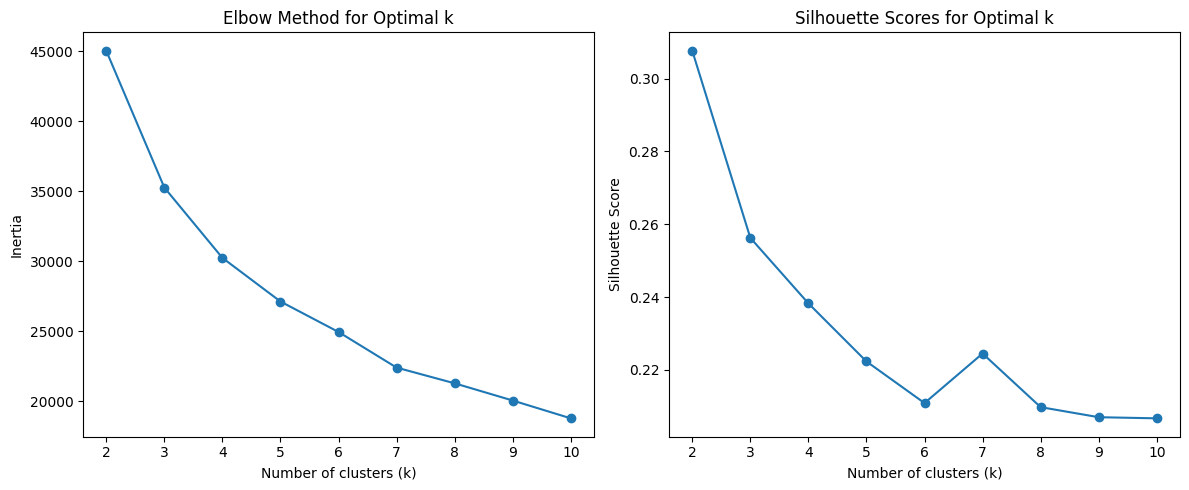


Selected optimal k = 4 (default, please verify from plots).
Please analyze the plots above to confirm if k=4 is appropriate.

### K-Means Clustering Results (k=4)
Cluster distribution:
Cluster
0    2375
1    1975
2    2230
3    2777
Name: count, dtype: int64

Generating cluster pairplot...
Saved cluster pairplot to: modelling_analysis_results\clustering_pairplot.png


<Figure size 1200x1000 with 0 Axes>

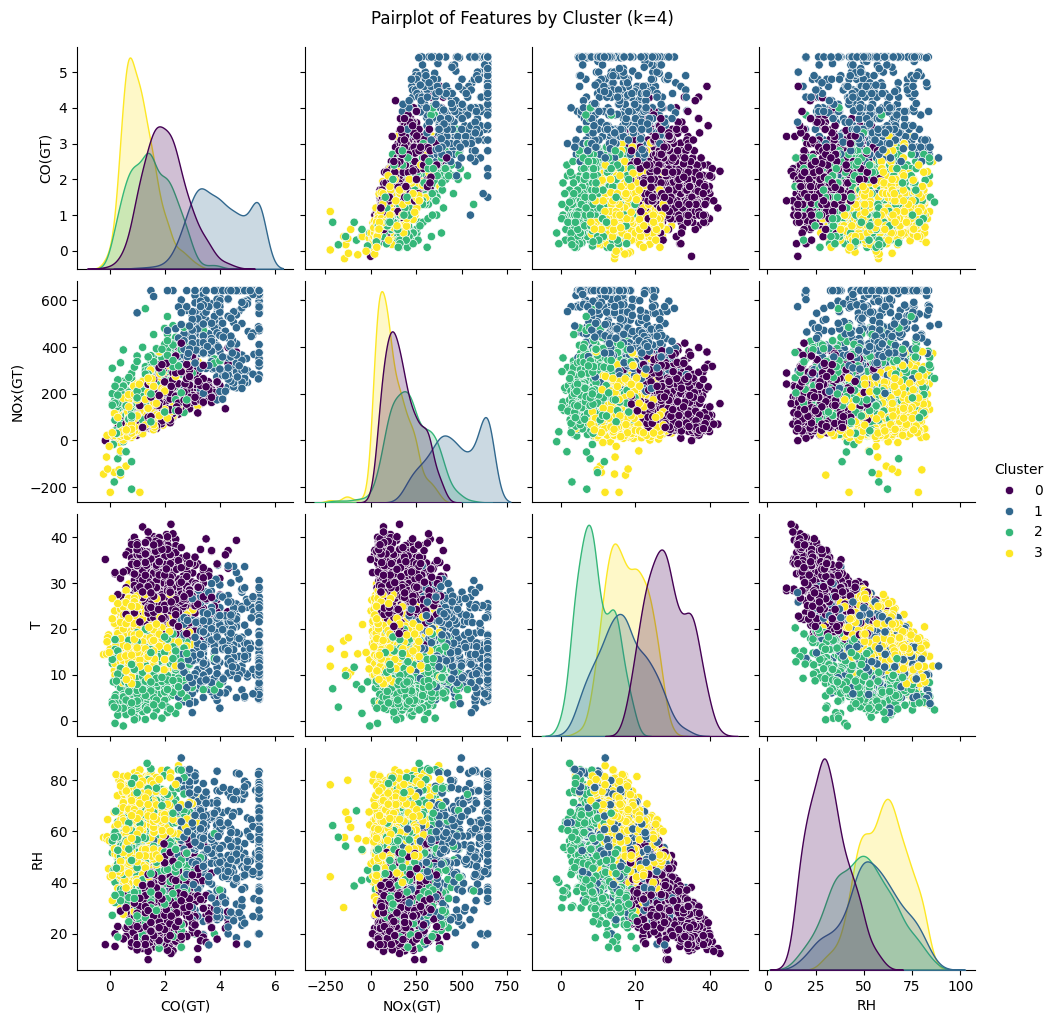


**Cluster Centroids (Mean Values):**
           CO(GT)     NOx(GT)     NO2(GT)   C6H6(GT)          T         RH  \
Cluster                                                                      
0        2.012981  168.470943  104.068920  11.121653  28.707919  31.220426   
1        3.997917  478.904118  155.829782  19.881415  16.280610  54.548293   
2        1.535603  216.308222  122.753980   6.068867   9.422480  49.193035   
3        1.127380  118.891652   72.726013   5.167048  17.912131  59.701253   

               AH  
Cluster            
0        1.181384  
1        1.021370  
2        0.579885  
3        1.225638  

Generating centroids heatmap...
Saved centroids heatmap to: modelling_analysis_results\clustering_centroids_heatmap.png


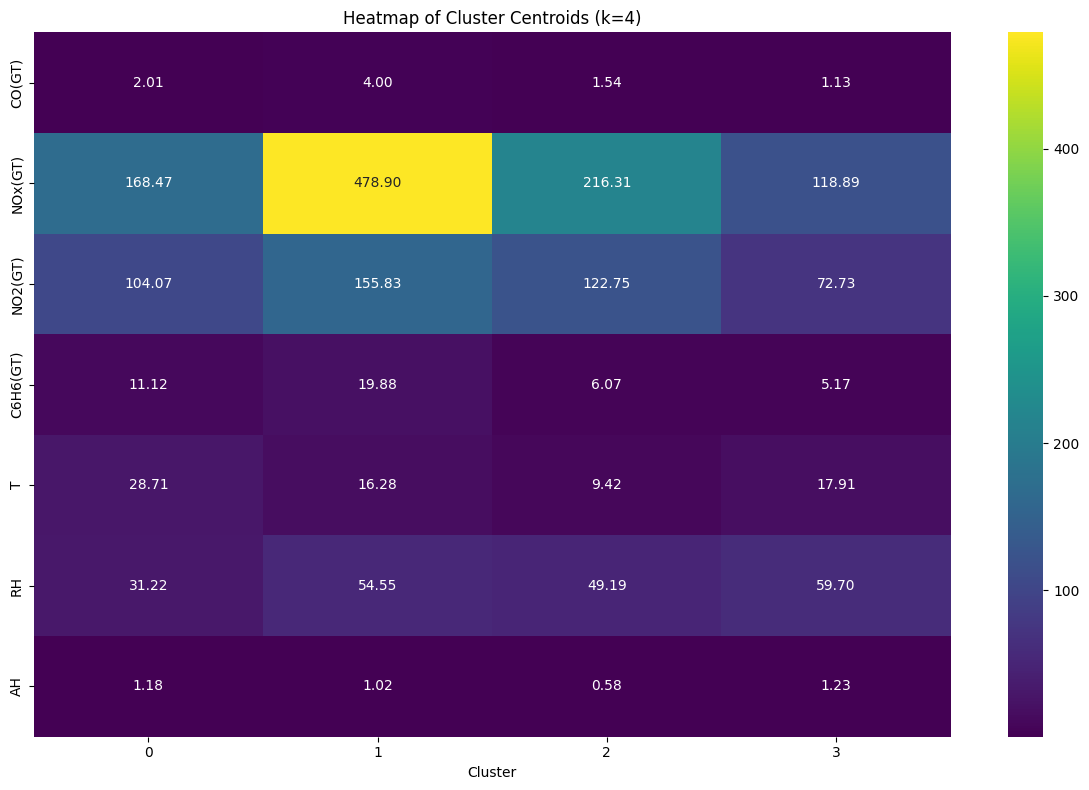


### Clustering Summary
K-Means clustering with k=4 was performed. The clusters represent different typical air quality and environmental conditions. Detailed interpretation of centroids helps understand these profiles.

Clustering Analysis completed.


In [87]:


# Print report introduction directly to console
print("\n# Clustering Analysis Report")
print(f"\nClustering analysis performed using {sample_fraction*100}% of the data.")
print("\n### Objective")
print("The objective of clustering analysis is to identify distinct groups or patterns in the air quality data based on pollutant concentrations and environmental factors.")

# Feature Selection for Clustering
features_clustering = ["CO(GT)", "NOx(GT)", "NO2(GT)", "C6H6(GT)", "T", "RH", "AH"]
available_features_clu = [col for col in features_clustering if col in df.columns]

if not available_features_clu or len(available_features_clu) < 2:
    print("\nNot enough suitable features found for clustering. Skipping clustering.")
else:
    print("\n### Feature Selection")
    print(f"* Features for Clustering: {available_features_clu}")
    
    df_cluster = df[available_features_clu].copy()
    df_cluster = df_cluster.fillna(df_cluster.mean()) # Handle any remaining NaNs

    # Scale features for clustering
    scaler_clu = StandardScaler()
    df_scaled_clu = scaler_clu.fit_transform(df_cluster)

    print("\n### Determining Optimal Number of Clusters")
    # Silhouette score is only defined for k >= 2
    inertia = []
    silhouette_scores = []
    k_range = range(2, 11)  # Test k from 2 to 10
    print(f"Testing k values: {list(k_range)}")

    print("Calculating optimal k for K-Means...")
    for k_val in k_range:
        kmeans = KMeans(n_clusters=k_val, random_state=42, n_init="auto")
        kmeans.fit(df_scaled_clu)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df_scaled_clu, kmeans.labels_))
        print(f"Completed k={k_val}")
    
    # Display plots and save them
    # Create output directory if it doesn't exist
    output_dir = "modelling_analysis_results"
    os.makedirs(output_dir, exist_ok=True)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal k")
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, marker="o")  # Now k_range and silhouette_scores have the same length
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Scores for Optimal k")
    plt.tight_layout()
    
    # Save plot
    k_selection_path = os.path.join(output_dir, "clustering_k_selection.png")
    plt.savefig(k_selection_path)
    print(f"Saved optimal k selection plots to: {k_selection_path}")
    
    # Display plot
    plt.show()
    
    # User should inspect the plots to choose optimal_k
    # For this script, we will pick a default, e.g., 4, but encourage user to modify.
    optimal_k = 4 
    print(f"\nSelected optimal k = {optimal_k} (default, please verify from plots).")
    print(f"Please analyze the plots above to confirm if k={optimal_k} is appropriate.")

    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
    df["Cluster"] = kmeans.fit_predict(df_scaled_clu)

    print(f"\n### K-Means Clustering Results (k={optimal_k})")
    print("Cluster distribution:")
    print(df['Cluster'].value_counts().sort_index())

    cluster_plot_features = ["CO(GT)", "NOx(GT)", "T", "RH", "Cluster"]
    cluster_plot_features = [feat for feat in cluster_plot_features if feat in df.columns]
    if len(cluster_plot_features) > 1:
        print("\nGenerating cluster pairplot...")
        plt.figure(figsize=(12,10))
        sample_df_for_plot = df[cluster_plot_features].sample(n=min(2000, len(df)), random_state=42) if len(df) > 2000 else df[cluster_plot_features]
        sns.pairplot(sample_df_for_plot, hue="Cluster", palette="viridis", diag_kind="kde")
        plt.suptitle(f"Pairplot of Features by Cluster (k={optimal_k})", y=1.02)
        
        # Save pairplot
        cluster_pairplot_path = os.path.join(output_dir, "clustering_pairplot.png")
        plt.savefig(cluster_pairplot_path)
        print(f"Saved cluster pairplot to: {cluster_pairplot_path}")
        
        # Display pairplot
        plt.show()

    centroids = df.groupby("Cluster")[available_features_clu].mean()
    print("\n**Cluster Centroids (Mean Values):**")
    print(centroids)
    
    print("\nGenerating centroids heatmap...")
    plt.figure(figsize=(12, 8))
    sns.heatmap(centroids.T, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"Heatmap of Cluster Centroids (k={optimal_k})")
    plt.tight_layout()
    
    # Save heatmap
    centroids_heatmap_path = os.path.join(output_dir, "clustering_centroids_heatmap.png")
    plt.savefig(centroids_heatmap_path)
    print(f"Saved centroids heatmap to: {centroids_heatmap_path}")
    
    # Display heatmap
    plt.show()
    
    print("\n### Clustering Summary")
    print(f"K-Means clustering with k={optimal_k} was performed. The clusters represent different typical air quality and environmental conditions. Detailed interpretation of centroids helps understand these profiles.")

print("\nClustering Analysis completed.")